<a href="https://colab.research.google.com/github/marytonwe/OPTIC-ER/blob/main/OPTIC_ER_Training_and_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Dependecies
!pip install osmnx geopandas scikit-learn matplotlib seaborn gymnasium torch -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 2.8 MB/s eta 0:00:00


In [ ]:
# Clean and remount (safe for reruns)
import shutil, os
from google.colab import drive

mount_path = '/content/drive'

# Only delete if already mounted AND has temporary local content
if os.path.ismount(mount_path):
    drive.flush_and_unmount()  # safely unmount

if os.path.exists(mount_path) and os.listdir(mount_path):
    shutil.rmtree(mount_path)

# Remount Drive
drive.mount(mount_path, force_remount=True)

Mounted at /content/drive


In [ ]:
# =============================================================================
# OPTIC-ER: Final Release v1.0
# It includes a safe archiving function to preserve previous results
# before starting a new run.
# =============================================================================

# -----------------------------------------------------------------------------
# PART 1: SETUP AND DATA PREPARATION
# -----------------------------------------------------------------------------
print("--- Part 1: Initializing Project & Data ---")

# --- Step 1.1: Import All Libraries ---
import os, geopandas as gpd, pandas as pd, numpy as np, osmnx as ox, networkx as nx
import gymnasium as gym, torch, torch.nn as nn, torch.optim as optim, random, pickle, time
from gymnasium import spaces; from torch.distributions import Categorical
from tqdm.notebook import tqdm; import matplotlib.pyplot as plt
from shapely.geometry import Point, MultiPoint, box; import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
import zipfile, requests, io
from matplotlib import patheffects as pe
from matplotlib.patches import Patch
from datetime import datetime

# --- Step 1.2: Centralized Configuration ---
class Config:
    PROJECT_FOLDER = '/content/drive/MyDrive/OpticER_MLP_Baseline'
    DATA_FOLDER = os.path.join(PROJECT_FOLDER, 'data')
    REPORTS_FOLDER = os.path.join(PROJECT_FOLDER, 'reports')
    MODEL_SAVE_PATH = os.path.join(PROJECT_FOLDER, 'optic_er_a2c_MLP_AGENT_BASELINE.pth')
    CACHE_FILE_PATH = os.path.join(DATA_FOLDER, 'travel_time_cache_STRATIFIED_FINAL.pkl')
    FACILITIES_FILE = 'existing_facilities.geojson'; PLACE_NAME = "Rivers State, Nigeria"; CRS = "EPSG:4326"
    N_INCIDENTS = 2000; N_EPOCHS = 3500; ROLLOUT_LEN = 128
    LEARNING_RATE = 1e-4; GAMMA = 0.99; ENTROPY_COEFF = 0.01
    N_CATEGORIES = 4; TIME_PENALTY_PER_MINUTE = 0.1; NUM_SERVICE_ZONES = 15

config = Config()
os.makedirs(config.REPORTS_FOLDER, exist_ok=True)
print(f"Project folders ensured at: {config.PROJECT_FOLDER}")

# --- STEP 1.3: Safe Archiving of Previous Results ---
def archive_previous_results(config):
    """Checks for and renames old model and cache files to prevent overwriting."""
    print("\n--- Archiving previous results... ---")
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    files_to_archive = [config.MODEL_SAVE_PATH, config.CACHE_FILE_PATH]
    for f_path in files_to_archive:
        if os.path.exists(f_path):
            base, ext = os.path.splitext(f_path)
            archive_path = f"{base}_archive_{timestamp}{ext}"
            print(f"   > Found old file: {os.path.basename(f_path)}")
            print(f"   > Renaming to: {os.path.basename(archive_path)}")
            os.rename(f_path, archive_path)
    print("✅ Archiving complete.")

archive_previous_results(config)

# --- Step 1.4: Load Foundational Geospatial Data ---
facilities_gdf = gpd.read_file(os.path.join(config.DATA_FOLDER, config.FACILITIES_FILE))
rivers_state_boundary_gdf = ox.geocode_to_gdf(config.PLACE_NAME)
rivers_state_polygon = rivers_state_boundary_gdf.unary_union
LGA_SHP_PATH = os.path.join(config.DATA_FOLDER, "rivers_lgas.shp")
if not os.path.exists(LGA_SHP_PATH):
    url="https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_NGA_shp.zip"; r=requests.get(url); z=zipfile.ZipFile(io.BytesIO(r.content)); z.extractall("gadm_nigeria_lga")
    nga_lgas = gpd.read_file("gadm_nigeria_lga/gadm41_NGA_2.shp"); rivers_lgas_gdf = nga_lgas[nga_lgas['NAME_1'] == 'Rivers'].copy(); rivers_lgas_gdf.to_file(LGA_SHP_PATH)
rivers_lgas_gdf = gpd.read_file(LGA_SHP_PATH)
print("✅ Foundational geospatial data loaded.")

# --- Step 1.5: Definitive Incident Generation ---
def generate_incidents_v4_complete_coverage(n, state_polygon, lga_gdf):
    print("Generating FINAL high-fidelity, complete coverage incident data...")
    incident_data = []; all_categories = ["healthcare", "fire_disaster", "security", "transport"]
    N_PER_LGA_CAT = 3
    print(f"   > Ensuring baseline coverage with {N_PER_LGA_CAT} incidents per category in every LGA...")
    for _, lga_row in tqdm(lga_gdf.iterrows(), total=len(lga_gdf), desc="Stratified LGA Sampling"):
        lga_geom = lga_row.geometry; minx, miny, maxx, maxy = lga_geom.bounds
        for cat in all_categories:
            count = 0; attempts = 0
            while count < N_PER_LGA_CAT and attempts < 200:
                point = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
                if lga_geom.contains(point): incident_data.append({'category': cat, 'geometry': point}); count += 1
                attempts += 1
    print(f"   > Adding {n - len(incident_data)} population-weighted hotspot incidents...")
    hotspots={'Port Harcourt City':{'coords':(7.01,4.81),'weights':[0.3,0.2,0.4,0.1]},'Obio-Akpor':{'coords':(7.05,4.85),'weights':[0.4,0.1,0.3,0.2]}}
    while len(incident_data) < n:
        spot_name = random.choice(list(hotspots.keys())); center_lon, center_lat = hotspots[spot_name]['coords']; spot_weights = hotspots[spot_name]['weights']
        point=Point(center_lon+np.random.randn()*0.03,center_lat+np.random.randn()*0.03)
        if state_polygon.contains(point): incident_data.append({'category':random.choices(all_categories,weights=spot_weights,k=1)[0],'geometry':point})
    print(f"✅ Final complete coverage dataset with {len(incident_data)} incidents generated.")
    return gpd.GeoDataFrame(incident_data,crs="EPSG:4326",geometry='geometry').reset_index().rename(columns={'index':'incident_id'})
random.seed(42); np.random.seed(42); torch.manual_seed(42)
incidents_gdf = generate_incidents_v4_complete_coverage(config.N_INCIDENTS, rivers_state_polygon, rivers_lgas_gdf)

# --- Step 1.6: Final Preprocessing ---
graph_path = os.path.join(config.DATA_FOLDER, 'rivers_state_drive.graphml'); G = ox.load_graphml(graph_path)
facility_cat_map = {"Healthcare": 0, "Fire/Disaster": 1, "Security": 2, "Transport Access": 3}; incident_cat_map = {"healthcare": 0, "fire_disaster": 1, "security": 2, "transport": 3}
facilities_gdf['category_encoded'] = facilities_gdf['category'].map(facility_cat_map); facilities_gdf.dropna(subset=['category_encoded'], inplace=True); facilities_gdf['category_encoded'] = facilities_gdf['category_encoded'].astype(int)
incidents_gdf['category_encoded'] = incidents_gdf['category'].map(incident_cat_map)
facilities_gdf['nearest_node'] = ox.nearest_nodes(G, facilities_gdf['geometry'].x, facilities_gdf['geometry'].y)
incidents_gdf['nearest_node'] = ox.nearest_nodes(G, incidents_gdf['geometry'].x, incidents_gdf['geometry'].y)
print(f"\n--- Part 1 Setup Complete ---\n")

--- Part 1: Initializing Project & Data ---
Project folders ensured at: /content/drive/MyDrive/OpticER_MLP_Baseline

--- Archiving previous results... ---
   > Found old file: travel_time_cache_STRATIFIED_FINAL.pkl
   > Renaming to: travel_time_cache_STRATIFIED_FINAL_archive_20251009_111307.pkl
✅ Archiving complete.


/tmp/ipython-input-897172007.py:60: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  rivers_state_polygon = rivers_state_boundary_gdf.unary_union


✅ Foundational geospatial data loaded.
Generating FINAL high-fidelity, complete coverage incident data...
   > Ensuring baseline coverage with 3 incidents per category in every LGA...


Stratified LGA Sampling:   0%|          | 0/23 [00:00<?, ?it/s]

   > Adding 1724 population-weighted hotspot incidents...
✅ Final complete coverage dataset with 2000 incidents generated.

--- Part 1 Setup Complete ---



In [ ]:
# Display preview of the incident data
incidents_gdf.head()

# Count incidents per category
incident_counts = incidents_gdf['category'].value_counts().reset_index()
incident_counts.columns = ['Incident Type', 'Frequency']

# Display the incident type distribution
incident_counts

,Incident Type,Frequency
0,healthcare,665
1,security,661
2,transport,338
3,fire_disaster,336


In [ ]:
# =============================================================================
# PART 2: THE HIGH-PERFORMANCE MAPPING AGENT ENVIRONMENT
# =============================================================================
class OpticErEnv(gym.Env):
    def __init__(self, facilities_gdf, incidents_gdf, graph, config):
        super().__init__(); print("Initializing High-Performance Environment..."); self.graph,self.config=graph,config; self.facilities_gdf,self.incidents_gdf=facilities_gdf,incidents_gdf
        self.n_facilities,self.n_incidents,self.n_categories=len(facilities_gdf),len(incidents_gdf),config.N_CATEGORIES; self.facilities_nodes,self.facilities_categories=facilities_gdf['nearest_node'].values,facilities_gdf['category_encoded'].values
        self.incidents_nodes,self.incidents_categories=incidents_gdf['nearest_node'].values,incidents_gdf['category_encoded'].values; self.action_space=spaces.Discrete(self.n_facilities)
        state_size=self.n_categories+(self.n_facilities*3); self.observation_space=spaces.Box(low=-1,high=1,shape=(state_size,),dtype=np.float32)
        self.travel_time_cache={}; self.all_incident_times_matrix=np.full((self.n_incidents,self.n_facilities),np.nan); self.current_incident_idx=0

    def build_time_matrix(self, cache_file_path):
        """
        Calculates all travel times using a clean one-to-many approach for each unique incident node.
        """
        # If a valid cache path is provided and the file exists, load it.
        if cache_file_path and os.path.exists(cache_file_path):
            print(f"✅ Found existing complete cache file. Loading...");
            with open(cache_file_path, 'rb') as f:
                self.travel_time_cache = pickle.load(f)
        else:
            print("⚠️ Cache not found. Generating a new one")
            self.travel_time_cache = {}

        # Get the unique sets of nodes we need to compute routes for.
        unique_incident_nodes = set(np.unique(self.incidents_nodes))
        unique_facility_nodes = set(np.unique(self.facilities_nodes))

        # Check which incident nodes still need to be processed.
        # We check if the first facility is in the cache for a given incident node.
        # This is a proxy for whether the incident node has been processed.
        processed_incident_nodes = {o for o, d in self.travel_time_cache.keys() if d == list(unique_facility_nodes)[0]}
        incident_nodes_to_process = list(unique_incident_nodes - processed_incident_nodes)

        if not incident_nodes_to_process:
            print("✅ All necessary routes are already in the loaded cache.")
        else:
            print(f"   > Resuming computation for {len(incident_nodes_to_process)} unprocessed incident nodes...")
            # --- THE ONE-TO-MANY LOOP ---
            for origin in tqdm(incident_nodes_to_process, desc="Processing Incident Locations"):
                try:
                    # Calculate path lengths from this ONE origin to ALL other nodes in the graph.
                    lengths = nx.shortest_path_length(self.graph, source=origin, weight='length')

                    # Now, store the results for just the facility nodes we care about.
                    for dest in unique_facility_nodes:
                        length_in_meters = lengths.get(dest) # Get the length if the destination was reached
                        if length_in_meters is not None:
                            self.travel_time_cache[(origin, dest)] = (length_in_meters / 11.1) / 60
                        else:
                            self.travel_time_cache[(origin, dest)] = np.nan
                except nx.NodeNotFound:
                    # If the origin node itself is disconnected, all paths from it are impossible.
                    for dest in unique_facility_nodes:
                        self.travel_time_cache[(origin, dest)] = np.nan

            # Save the complete cache to disk so we never have to do this again.
            if cache_file_path:
                print(f"\n💾 Saving complete cache with {len(self.travel_time_cache)} routes...")
                with open(cache_file_path, 'wb') as f:
                    pickle.dump(self.travel_time_cache, f)
                print("   Save complete.")

        print("\nBuilding final numpy matrix from cache (fast)...")
        mapper=np.vectorize(lambda o,d: self.travel_time_cache.get((o,d),np.nan)); self.all_incident_times_matrix=mapper(self.incidents_nodes[:,np.newaxis], self.facilities_nodes); print("✅ Time matrix built.")

    def get_action_mask(self,i): return (self.facilities_categories==self.incidents_categories[i])&(~np.isnan(self.all_incident_times_matrix[i]))
    def _get_state(self,i):
        times=self.all_incident_times_matrix[i]; valid_mask=self.get_action_mask(i)
        if np.any(valid_mask): best_time=np.min(times[valid_mask]); time_deltas=times-best_time; norm_deltas=np.clip(np.nan_to_num(time_deltas,nan=60.0)/60.0,0,1)
        else: norm_deltas=np.zeros_like(times)
        return np.concatenate((np.eye(self.n_categories)[self.incidents_categories[i]],np.stack((np.clip(np.nan_to_num(times,nan=120.0)/120.0,0,1),(~np.isnan(times)).astype(float),norm_deltas),axis=1).flatten())).astype(np.float32)
    def step(self,a):
        i=self.current_incident_idx; valid_mask=self.get_action_mask(i)
        if not valid_mask[a]: reward=-2.0; info={'error':'impossible action'}
        else:
            valid_times=self.all_incident_times_matrix[i][valid_mask]; best_time=np.min(valid_times); chosen_time=self.all_incident_times_matrix[i,a]; time_delta=chosen_time-best_time
            reward=1.0-(self.config.TIME_PENALTY_PER_MINUTE*time_delta); info={'chosen_time':chosen_time,'best_time':best_time,'reward':reward}
        next_state,_=self.reset(); return next_state,reward,True,False,info
    def reset(self,*,seed=None,options=None):
        if seed is not None: super().reset(seed=seed); np.random.seed(seed)
        self.current_incident_idx=np.random.randint(0,self.n_incidents); return self._get_state(self.current_incident_idx),{}

# =============================================================================
# PART 2: VALID ENVIRONMENT TEST
# =============================================================================

# --- VALID Environment Test ---

# 1. Create the environment instance
print("--- Testing the final environment initialization ---")
env = OpticErEnv(facilities_gdf, incidents_gdf, G, config)

# 2. Call the master build function with the correct cache path from Config
env.build_time_matrix(config.CACHE_FILE_PATH)

# 3. Safely test the environment
print("\n--- Testing the fully initialized environment's functionality ---")
initial_state, _ = env.reset()
action_mask = env.get_action_mask(env.current_incident_idx)
valid_actions = np.where(action_mask)[0]

if len(valid_actions) > 0:
    sample_action = np.random.choice(valid_actions)
    next_state, reward, done, _, info = env.step(sample_action)
    print("\n✅ Environment test successful with a VALID action.")
    print(f"   State shape: {initial_state.shape} (Correct!)")
    print(f"   Sample step reward: {reward:.2f}")
    print(f"   Returned Info: {info}")
    print(f"   Episode Done Flag: {done} (Should be True)")
else:
    print(f"⚠️ Warning: No valid action found for the first incident (Index: {env.current_incident_idx}).")

print("\n--- ✅✅✅ Part 2 Environment Test Complete. All systems nominal. ✅✅✅ ---")

--- Testing the final environment initialization ---
Initializing High-Performance Environment...
⚠️ Cache not found. Generating a new one
   > Resuming computation for 1660 unprocessed incident nodes...


Processing Incident Locations:   0%|          | 0/1660 [00:00<?, ?it/s]


💾 Saving complete cache with 212480 routes...
   Save complete.

Building final numpy matrix from cache (fast)...
✅ Time matrix built.

--- Testing the fully initialized environment's functionality ---

✅ Environment test successful with a VALID action.
   State shape: (559,) (Correct!)
   Sample step reward: 0.05
   Returned Info: {'chosen_time': np.float64(16.32826907350178), 'best_time': np.float64(6.852006029192355), 'reward': np.float64(0.052373695569057466)}
   Episode Done Flag: True (Should be True)

--- ✅✅✅ Part 2 Environment Test Complete. All systems nominal. ✅✅✅ ---



--- Part 3: Initializing Training ---
Initializing High-Performance Environment...
--- Using cache file: /content/drive/MyDrive/OpticER_MLP_Baseline/data/travel_time_cache_STRATIFIED_FINAL.pkl ---
✅ Found existing complete cache file. Loading...
✅ All necessary routes are already in the loaded cache.

Building final numpy matrix from cache (fast)...
✅ Time matrix built.
--- MLPActorCritic Model Initialized ---
   > Input State Dim: 559
   > Hidden Dim: 256
   > Output Action Dim: 185

🚀 Starting Final Training Run...


Training Final Model:   0%|          | 0/3500 [00:00<?, ?it/s]

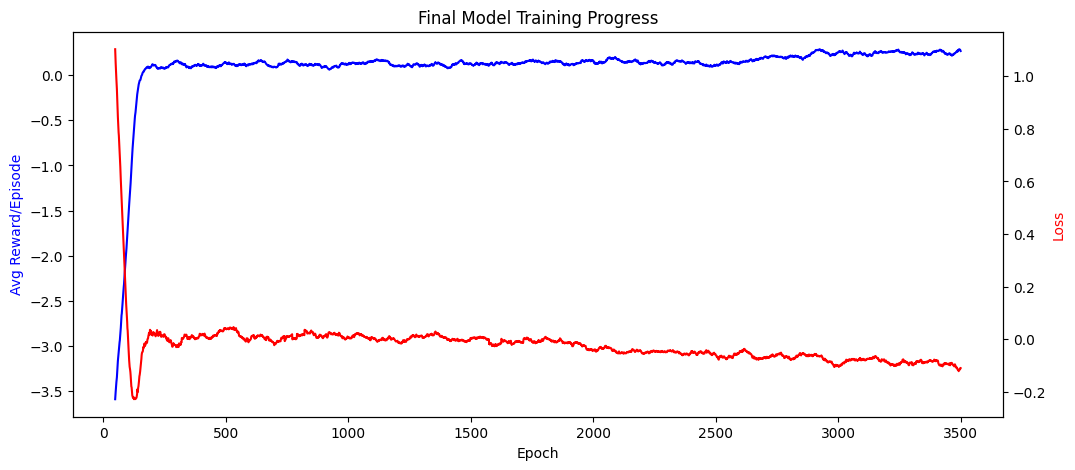

In [ ]:
# =============================================================================
# PART 3: THE ATTENTION AGENT AND TRAINING
# =============================================================================

class MLPActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(MLPActorCritic, self).__init__()
        # A shared network to process the state
        self.shared_net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        # The Actor head: outputs action logits
        self.actor_head = nn.Linear(hidden_dim, action_dim)
        # The Critic head: outputs a single state value
        self.critic_head = nn.Linear(hidden_dim, 1)
        print("--- MLPActorCritic Model Initialized ---")
        print(f"   > Input State Dim: {state_dim}")
        print(f"   > Hidden Dim: {hidden_dim}")
        print(f"   > Output Action Dim: {action_dim}")


    def forward(self, state):
        # The state is already a flat vector, perfect for an MLP
        shared_features = self.shared_net(state)

        # Get action logits from the actor head
        action_logits = self.actor_head(shared_features)

        # Get state value from the critic head
        state_value = self.critic_head(shared_features).squeeze(-1)

        return action_logits, state_value

print("\n--- Part 3: Initializing Training ---")
device=torch.device("cuda" if torch.cuda.is_available() else "cpu"); env=OpticErEnv(facilities_gdf,incidents_gdf,G,config)

print(f"--- Using cache file: {config.CACHE_FILE_PATH} ---")
env.build_time_matrix(config.CACHE_FILE_PATH)

state_dim,action_dim=env.observation_space.shape[0],env.action_space.n
n_facilities = len(facilities_gdf)

# Instantiate the Attention-based model
model = MLPActorCritic(state_dim, action_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
all_rewards,all_losses=[],[]; state,_=env.reset(seed=42)
print("\n🚀 Starting Final Training Run...")
for epoch in tqdm(range(config.N_EPOCHS),desc="Training Final Model"):
    log_probs,values,rewards,dones=[],[],[],[]
    for _ in range(config.ROLLOUT_LEN):
        mask=env.get_action_mask(env.current_incident_idx)
        if not np.any(mask): state,_=env.reset(); continue
        state_tensor=torch.tensor(state,dtype=torch.float32,device=device).unsqueeze(0)
        logits,value=model(state_tensor); logits.masked_fill_(~torch.tensor(mask,device=device),-float('inf')); dist=Categorical(logits=logits); action=dist.sample()
        _,reward,done,_,_=env.step(action.item()); log_probs.append(dist.log_prob(action)); values.append(value)
        rewards.append(torch.tensor([reward],device=device)); dones.append(torch.tensor([done],device=device)); state,_=env.reset()
    next_value=0; advantages=torch.zeros(len(rewards),device=device); last_adv=0
    for t in reversed(range(len(rewards))):
        delta=rewards[t]+config.GAMMA*next_value*(1-dones[t].float())-values[t]
        last_adv=delta+config.GAMMA*0.95*last_adv*(1-dones[t].float()); advantages[t]=last_adv; next_value=values[t]
    returns=advantages+torch.cat(values).detach(); advantages=(advantages-advantages.mean())/(advantages.std()+1e-8)
    actor_loss=-(torch.cat(log_probs)*advantages.detach()).mean(); critic_loss=nn.functional.smooth_l1_loss(torch.cat(values),returns)
    loss=actor_loss+0.5*critic_loss-config.ENTROPY_COEFF*dist.entropy().mean()
    all_losses.append(loss.item()); all_rewards.append(torch.cat(rewards).mean().item())
    optimizer.zero_grad(); loss.backward(); torch.nn.utils.clip_grad_norm_(model.parameters(),0.5); optimizer.step()
torch.save(model.state_dict(),config.MODEL_SAVE_PATH)
fig,ax1=plt.subplots(figsize=(12,5));ax1.set_xlabel('Epoch');ax1.set_ylabel('Avg Reward/Episode',color='b');ax1.plot(pd.Series(all_rewards).rolling(50).mean(),color='b');ax2=ax1.twinx();ax2.set_ylabel('Loss',color='r');ax2.plot(pd.Series(all_losses).rolling(50).mean(),color='r');plt.title('Final Model Training Progress');plt.show()


          PART 4: THE OPTIC-ER STRATEGIC POLICY ADVISOR
--- [A] Defining Service Level Benchmarks ---
   > Benchmarks for Critical and Life-Threatening response times are set.

--- [B] Generating and Classifying Full Dispatch Log ---


Analyzing All Incidents:   0%|          | 0/2000 [00:00<?, ?it/s]

✅ Full dispatch log generated and classified.

--- AGENT TACTICAL PERFORMANCE ---
✅ Agent Optimality Rate (choosing the best available option): 18.82%

--- [C] Generating Strategic Policy & Equity Report ---

--- STRATEGIC POLICY REPORT ---
              total_incidents  avg_best_response_time  ✅ Effective  \
service_zone                                                         
0                         475                    5.17    93.894737   
1                          22                   40.88    13.636364   
2                          27                   42.01    33.333333   
3                         328                    8.41    77.743902   
4                          17                   30.11    35.294118   
5                          54                   41.53     9.259259   
6                          16                   49.04    18.750000   
7                          22                   60.27     0.000000   
8                          22                   25.85    27

/tmp/ipython-input-2593365031.py:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=policy_report.reset_index(), x='service_zone', y='avg_best_response_time', ax=ax[1], palette='coolwarm')
/tmp/ipython-input-2593365031.py:121: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipython-input-2593365031.py:121: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE})

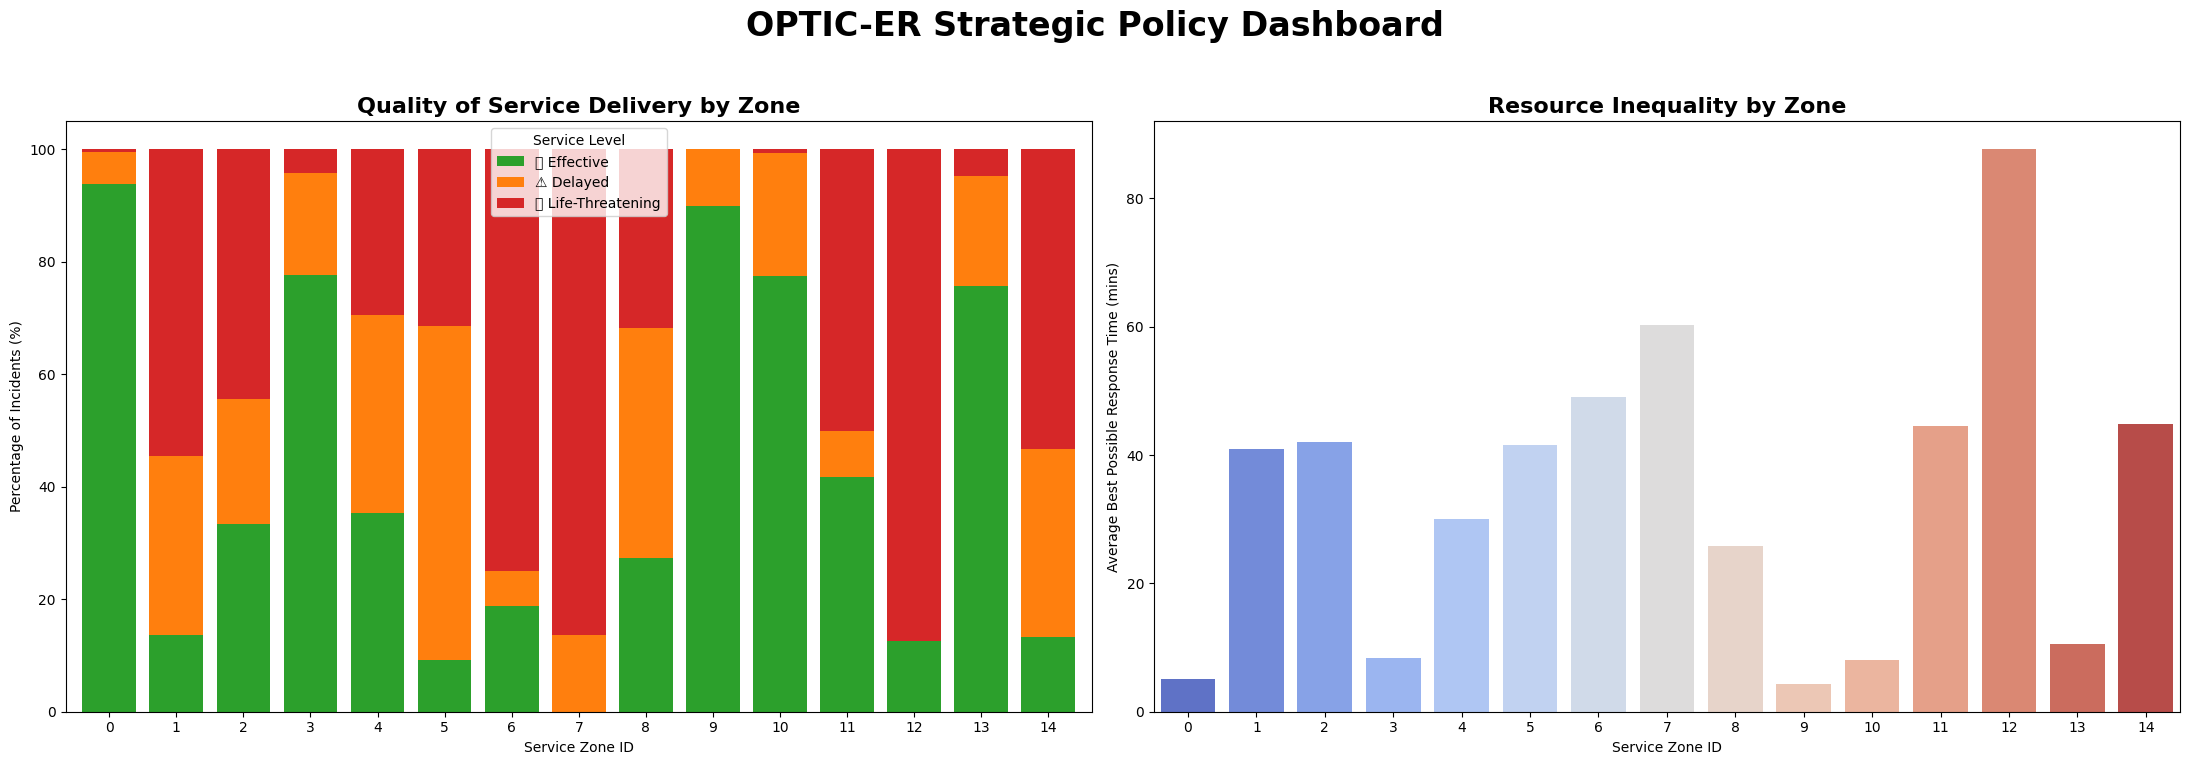

In [ ]:
# =============================================================================
# PART 4: THE OPTIC-ER STRATEGIC POLICY ADVISOR & ANALYSIS
# =============================================================================
from sklearn.cluster import KMeans
from shapely.geometry import MultiPoint

print("\n" + "="*60)
print(" " * 10 + "PART 4: THE OPTIC-ER STRATEGIC POLICY ADVISOR")
print("="*60)

def run_final_policy_and_performance_analysis(env, model, config):
    # --- 1. Define Service Level Benchmarks (Grounded in International Standards) ---
    print("--- [A] Defining Service Level Benchmarks ---")
    BENCHMARKS = {
        'healthcare': {'critical': 20, 'manageable': 45},
        'fire_disaster': {'critical': 8, 'manageable': 20},
        'security': {'critical': 10, 'manageable': 30},
        'transport': {'critical': 25, 'manageable': 50}
    }
    print("   > Benchmarks for Critical and Life-Threatening response times are set.")

    # --- 2. Generate the Full Dispatch Log & Classify Every Incident ---
    print("\n--- [B] Generating and Classifying Full Dispatch Log ---")
    incident_coords = np.array([incidents_gdf.geometry.x, incidents_gdf.geometry.y]).T
    kmeans = KMeans(n_clusters=config.NUM_SERVICE_ZONES, random_state=42, n_init='auto').fit(incident_coords)
    incidents_gdf['service_zone'] = kmeans.labels_

    dispatch_log = []
    for i in tqdm(range(env.n_incidents), desc="Analyzing All Incidents"):
        action_mask = env.get_action_mask(i)
        if not np.any(action_mask): continue # Skip unsolvable

        state = env._get_state(i)
        with torch.no_grad():
            logits,_ = model(torch.tensor(state, device=device).unsqueeze(0))
            logits.masked_fill_(~torch.tensor(action_mask, device=device), -float('inf'))
            action = torch.argmax(logits, dim=1).item()

        times = env.all_incident_times_matrix[i]
        best_time = np.min(times[action_mask])
        category = incidents_gdf.iloc[i]['category']

        # Classify the quality of the BEST POSSIBLE response
        status = '🔴 Life-Threatening'
        if best_time <= BENCHMARKS[category]['critical']:
            status = '✅ Effective'
        elif best_time <= BENCHMARKS[category]['manageable']:
            status = '⚠️ Delayed'

        dispatch_log.append({
            'incident_id': i, 'incident_category': category,
            'service_zone': incidents_gdf.iloc[i]['service_zone'],
            'agent_choice_is_optimal': np.isclose(times[action], best_time),
            'optimal_time_mins': best_time,
            'service_level_status': status
        })

    log_df = pd.DataFrame(dispatch_log)
    print("✅ Full dispatch log generated and classified.")

    # --- 3. Report on Agent's Tactical Performance ---
    optimality_rate = log_df['agent_choice_is_optimal'].mean() * 100
    print("\n--- AGENT TACTICAL PERFORMANCE ---")
    print(f"✅ Agent Optimality Rate (choosing the best available option): {optimality_rate:.2f}%")

    # --- 4. Generate the Strategic Policy Report ---
    print("\n--- [C] Generating Strategic Policy & Equity Report ---")

    # Calculate the percentage of each status per zone
    status_distribution = log_df.groupby(['service_zone', 'service_level_status']).size().unstack(fill_value=0)
    status_distribution = status_distribution.div(status_distribution.sum(axis=1), axis=0) * 100

    # Create the final report
    policy_report = log_df.groupby('service_zone').agg(
        total_incidents=('incident_id', 'count'),
        avg_best_response_time=('optimal_time_mins', 'mean')
    ).round(2)

    policy_report = pd.concat([policy_report, status_distribution], axis=1).fillna(0)

    # Generate Actionable Recommendations
    def get_recommendation(row):
        if row.get('🔴 Life-Threatening', 0) > 10: # If >10% of calls are life-threatening
            return "High Priority: New facilities or major road infrastructure required."
        elif row.get('⚠️ Delayed', 0) > 30: # If >30% of calls are delayed
            return "Medium Priority: Investigate road network improvements or add satellite posts."
        else:
            return "Low Priority: Monitor service levels."

    policy_report['Recommendation'] = policy_report.apply(get_recommendation, axis=1)

    report_path = os.path.join(config.REPORTS_FOLDER, 'strategic_policy_report.csv')
    policy_report.to_csv(report_path)

    print("\n--- STRATEGIC POLICY REPORT ---")
    print(policy_report[['total_incidents', 'avg_best_response_time', '✅ Effective', '⚠️ Delayed', '🔴 Life-Threatening', 'Recommendation']])
    print(f"\n✅ Detailed policy report saved to: {report_path}")

    # --- 5. Visualize the Policy Dashboard ---
    fig, ax = plt.subplots(1, 2, figsize=(22, 8))

    # Plot 1: The Quality of Service
    policy_report[['✅ Effective', '⚠️ Delayed', '🔴 Life-Threatening']].plot(
        kind='bar', stacked=True, ax=ax[0],
        color=['#2ca02c', '#ff7f0e', '#d62728'],
        width=0.8
    )
    ax[0].set_title('Quality of Service Delivery by Zone', fontsize=16, weight='bold')
    ax[0].set_ylabel('Percentage of Incidents (%)')
    ax[0].set_xlabel('Service Zone ID')
    ax[0].tick_params(axis='x', rotation=0)
    ax[0].legend(title="Service Level")

    # Plot 2: The underlying inequality
    sns.barplot(data=policy_report.reset_index(), x='service_zone', y='avg_best_response_time', ax=ax[1], palette='coolwarm')
    ax[1].set_title('Resource Inequality by Zone', fontsize=16, weight='bold')
    ax[1].set_ylabel('Average Best Possible Response Time (mins)')
    ax[1].set_xlabel('Service Zone ID')

    plt.suptitle('OPTIC-ER Strategic Policy Dashboard', fontsize=24, weight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- RUN THE FINAL ANALYSIS ---
run_final_policy_and_performance_analysis(env, model, config)


--- Part 5: Initializing Analysis & Reporting Suite ---
✅ All reports for this run will be saved in: /content/drive/MyDrive/OpticER_MLP_Baseline/reports/Policy_Engine_Report_2025-10-09_11-51-29
✅ All necessary assets (Model, LGA Shapes, Travel Atlas) loaded.

--- Generating Master Dispatch Log... ---


Analyzing All Incidents:   0%|          | 0/2000 [00:00<?, ?it/s]

✅ Master dispatch log with 1998 entries created.

               CURRENT STATE ASSESSMENT BY CATEGORY

--- LGA ID to Name Lookup Table ---


,lga_id,LGA_Name
0,0,Abua/Odual
1,1,Ahoada East
2,2,Ahoada West
3,3,Akuku-Toru
4,4,Andoni
5,5,Asari-Toru
6,6,Bonny
7,7,Degema
8,8,Eleme
9,9,Emuoha


/tmp/ipython-input-746798363.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  lga_status['dominant_status'].fillna('No Data', inplace=True); lga_status['plot_color'] = lga_status['dominant_status'].map(STATUS_PALETTE)
/tmp/ipython-input-746798363.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alway

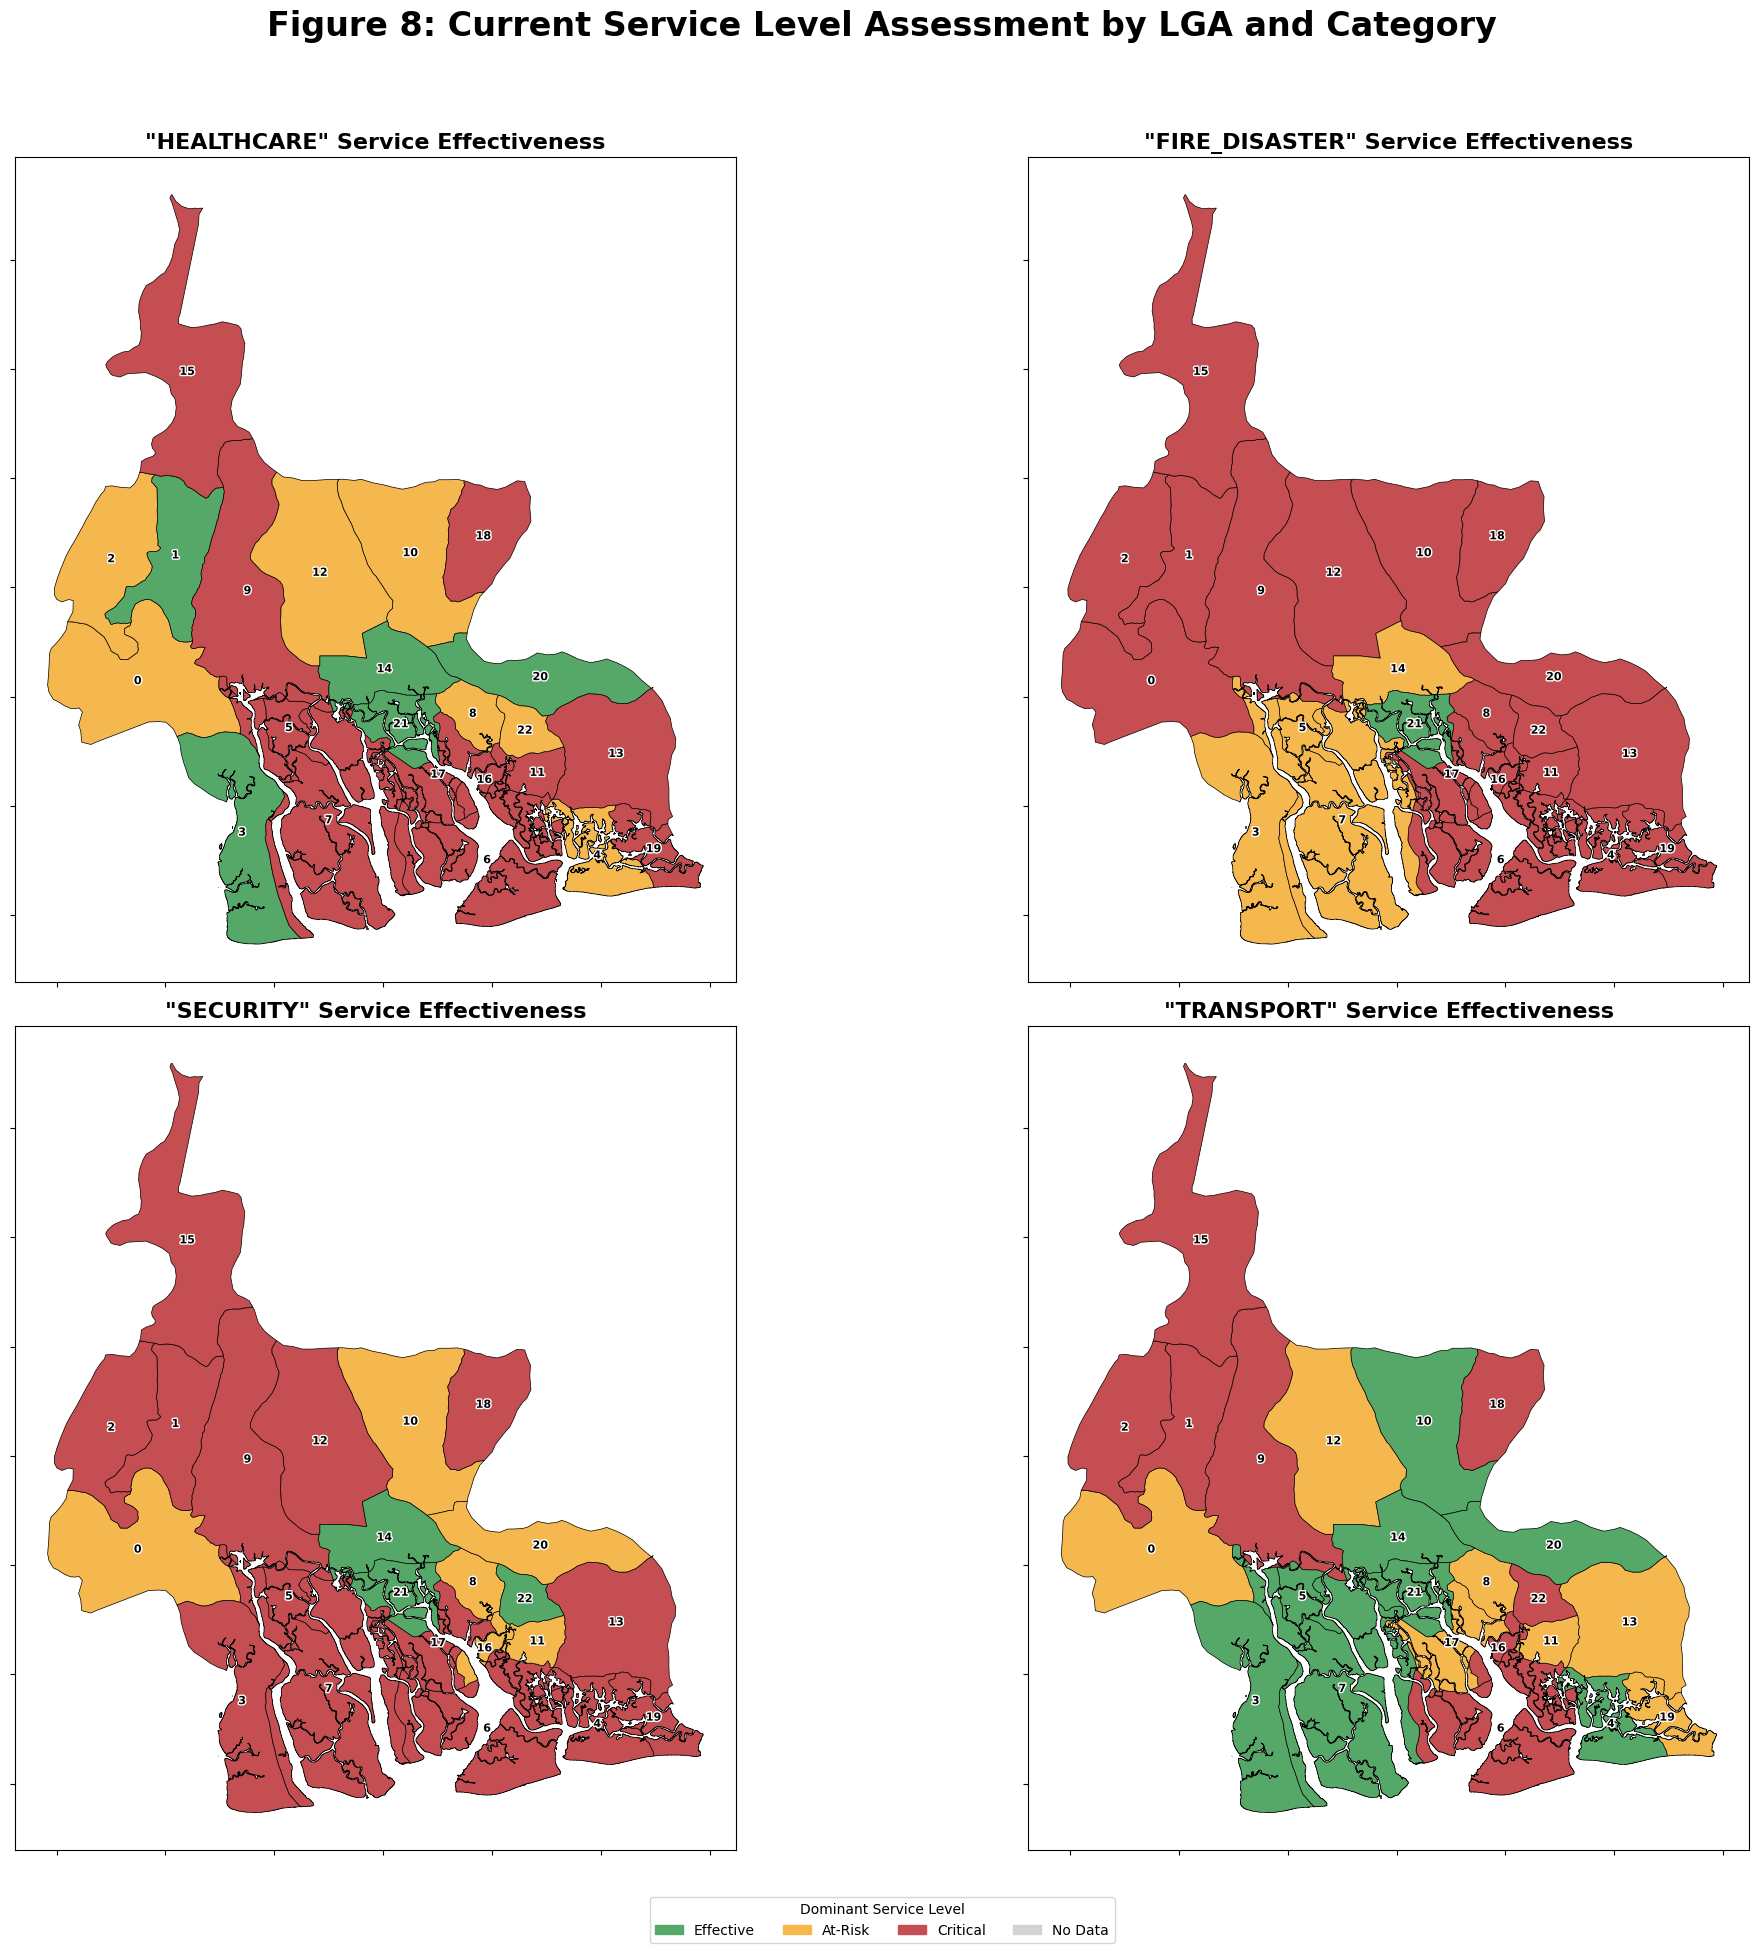

✅ Assessment maps saved to: /content/drive/MyDrive/OpticER_MLP_Baseline/reports/Policy_Engine_Report_2025-10-09_11-51-29/A_current_state_assessment_maps.png

--- Running 'Stateful LGA-Centric' Gap Elimination Engine ---


Optimizing Service Categories:   0%|          | 0/4 [00:00<?, ?it/s]

   - Analyzing LGAs for healthcare:   0%|          | 0/23 [00:00<?, ?it/s]

   - Analyzing LGAs for fire_disaster:   0%|          | 0/23 [00:00<?, ?it/s]

   - Analyzing LGAs for security:   0%|          | 0/23 [00:00<?, ?it/s]

   - Analyzing LGAs for transport:   0%|          | 0/23 [00:00<?, ?it/s]


               DEFINITIVE POLICY INTERVENTION PLAN


,LGA,facility_type_needed,num_new_facilities_required,avg_time_BEFORE,avg_time_AFTER,proposed_locations
0,Abua/Odual,healthcare,5,14.99,9.69,"[(4.813913752463153, 6.672118637915434), (4.81..."
1,Ahoada East,healthcare,1,6.92,3.12,"[(5.137811759696415, 6.673940627523871)]"
2,Ahoada West,healthcare,5,23.37,11.84,"[(5.0078808107677215, 6.474079118507789), (5.0..."
3,Akuku-Toru,healthcare,1,12.72,3.19,"[(4.698801391667713, 6.673700763474173)]"
4,Andoni,healthcare,1,13.66,4.10,"[(4.468635700558116, 7.4304376249623925)]"
5,Asari-Toru,healthcare,1,24.80,2.28,"[(4.693912512962616, 6.8745366730572695)]"
6,Bonny,healthcare,2,33.12,1.71,"[(4.552801810736381, 7.167778621503306), (4.55..."
7,Degema,healthcare,2,34.69,0.00,"[(4.4745721349477, 6.943947726089168), (4.4393..."
8,Eleme,healthcare,2,19.02,4.80,"[(4.75631144000443, 7.153836533227012), (4.707..."
9,Emuoha,healthcare,5,33.36,25.48,"[(4.966925942505252, 6.6810985954677315), (4.9..."



✅ Definitive policy plan saved to: /content/drive/MyDrive/OpticER_MLP_Baseline/reports/Policy_Engine_Report_2025-10-09_11-51-29/definitive_policy_plan.csv

--- Visualizing Strategic Intervention Plan by Category ---


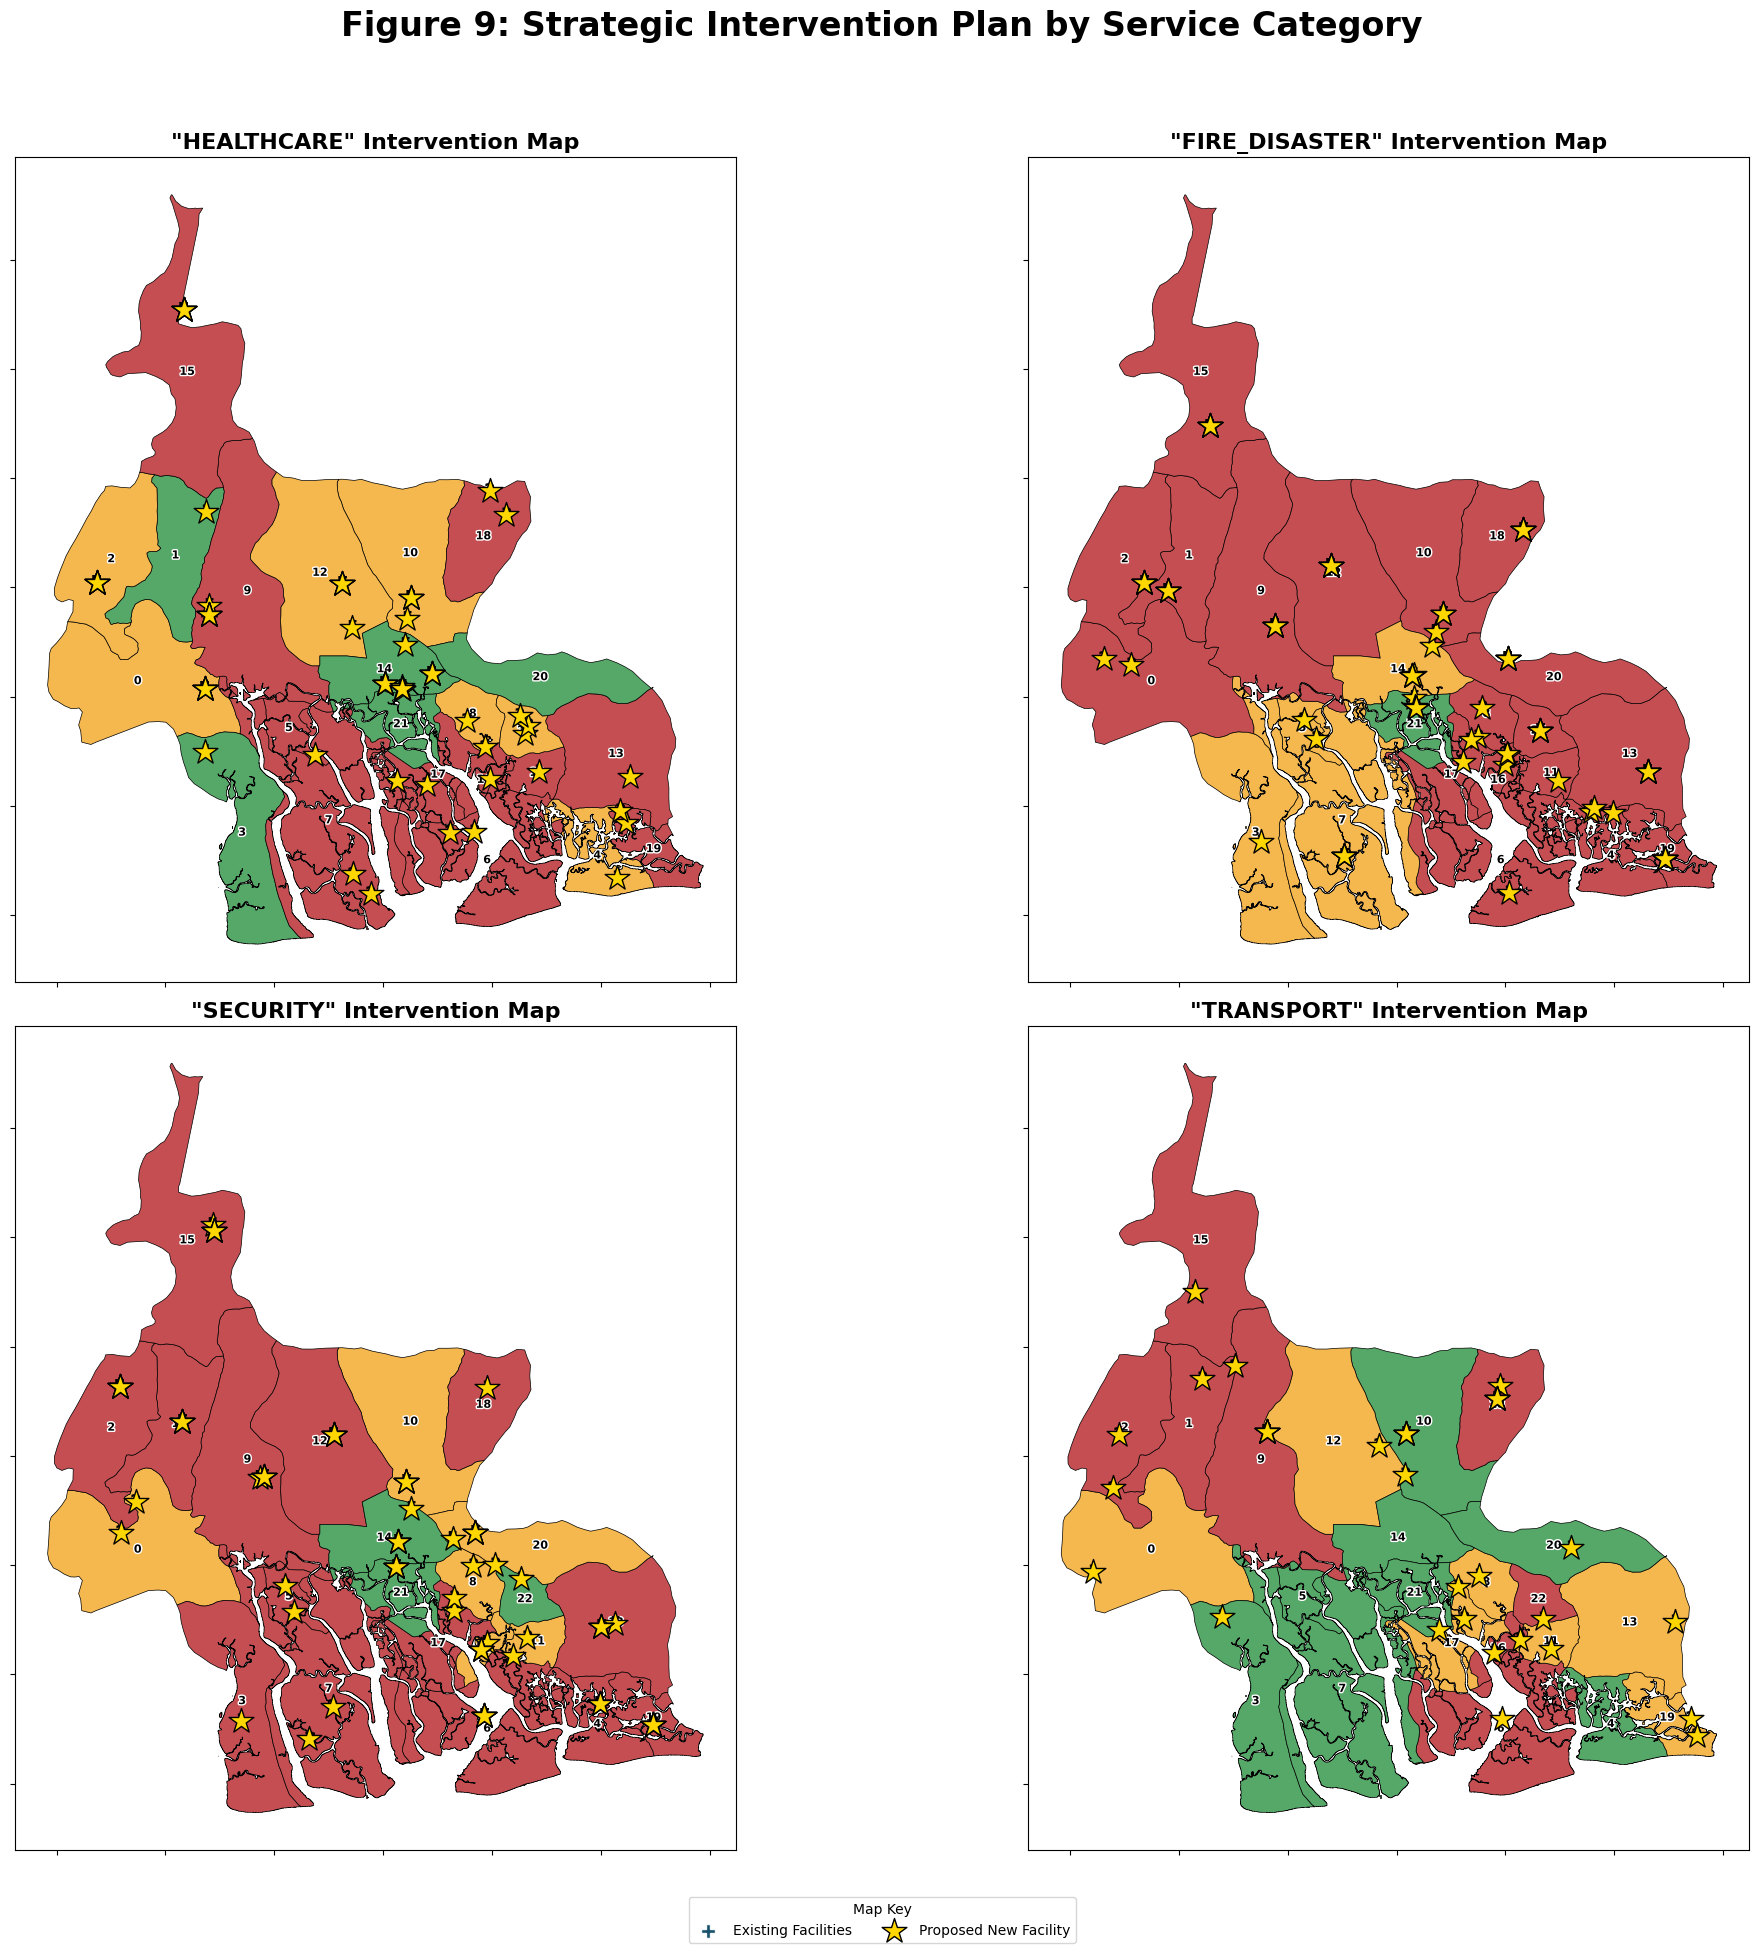

✅ Strategic Intervention Map Grid saved to: /content/drive/MyDrive/OpticER_MLP_Baseline/reports/Policy_Engine_Report_2025-10-09_11-51-29/B_strategic_intervention_maps_grid.png


In [ ]:
# =============================================================================
# PART 5: OPTIC-ER:THE ANALYSIS AND INTERVENTION ENGINE
# =============================================================================

# --- Step 1: Ensure all necessary libraries are loaded ---
import os, pandas as pd, numpy as np, geopandas as gpd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.cluster import DBSCAN
from shapely.geometry import Point, MultiPoint
from datetime import datetime
import networkx as nx
import osmnx as ox
from matplotlib import patheffects as pe
from matplotlib.patches import Patch
from tqdm.notebook import tqdm

print("\n--- Part 5: Initializing Analysis & Reporting Suite ---")

# --- Step 2: Load All Necessary Assets ---
model.load_state_dict(torch.load(config.MODEL_SAVE_PATH)); model.eval()
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
POLICY_REPORTS_FOLDER = os.path.join(config.REPORTS_FOLDER, f"Policy_Engine_Report_{timestamp}")
os.makedirs(POLICY_REPORTS_FOLDER, exist_ok=True)
print(f"✅ All reports for this run will be saved in: {POLICY_REPORTS_FOLDER}")
LGA_SHP_PATH = os.path.join(config.DATA_FOLDER, "rivers_lgas.shp")
rivers_lgas_gdf = gpd.read_file(LGA_SHP_PATH)
rivers_lgas_gdf['lga_id'] = range(len(rivers_lgas_gdf))
lga_lookup_df = rivers_lgas_gdf[['lga_id', 'NAME_2']].copy().rename(columns={'NAME_2': 'LGA_Name'})
with open(config.CACHE_FILE_PATH, 'rb') as f: travel_time_cache = pickle.load(f)
print("✅ All necessary assets (Model, LGA Shapes, Travel Atlas) loaded.")

# --- Step 3: Generate the Master Dispatch Log ---
print("\n--- Generating Master Dispatch Log... ---")
dispatch_log = []
for i in tqdm(range(env.n_incidents), desc="Analyzing All Incidents"):
    action_mask = env.get_action_mask(i)
    if not np.any(action_mask): continue
    state = env._get_state(i)
    with torch.no_grad():
        logits,_ = model(torch.tensor(state, device=device).unsqueeze(0)); logits.masked_fill_(~torch.tensor(action_mask, device=device), -float('inf')); action = torch.argmax(logits, dim=1).item()
    times = env.all_incident_times_matrix[i]; best_time = np.min(times[action_mask])
    dispatch_log.append({'incident_id': i, 'incident_category': incidents_gdf.iloc[i]['category'], 'optimal_time_mins': best_time})
dispatch_log_df = pd.DataFrame(dispatch_log)
log_path = os.path.join(POLICY_REPORTS_FOLDER, 'master_dispatch_log.csv'); dispatch_log_df.to_csv(log_path, index=False)
print(f"✅ Master dispatch log with {len(dispatch_log_df)} entries created.")

# --- Step 4: Map Incidents to LGAs and Classify Service Levels ---
if incidents_gdf.crs != rivers_lgas_gdf.crs: rivers_lgas_gdf = rivers_lgas_gdf.to_crs(incidents_gdf.crs)
incidents_with_lgas = gpd.sjoin(incidents_gdf, rivers_lgas_gdf[['lga_id', 'NAME_2', 'geometry']], how='left', predicate='within')
dispatch_log_df = pd.merge(dispatch_log_df, incidents_with_lgas[['incident_id', 'lga_id', 'NAME_2']], on='incident_id')

BENCHMARKS = {'healthcare':10.0, 'fire_disaster':8.0, 'security':10.0, 'transport':20.0}
def classify_service_level(row):
    t=row['optimal_time_mins']; cat=row['incident_category']; slo=BENCHMARKS.get(cat,15.0)
    if t <= slo: return 'Effective'
    if t <= slo + 15: return 'At-Risk'
    return 'Critical'
dispatch_log_df['service_level'] = dispatch_log_df.apply(classify_service_level, axis=1)

# --- Step 5: Generate "Current State" Assessment Maps (4 maps) ---
print("\n" + "="*70); print(" " * 15 + "CURRENT STATE ASSESSMENT BY CATEGORY"); print("="*70)
print("\n--- LGA ID to Name Lookup Table ---"); display(lga_lookup_df)
fig, axes = plt.subplots(2, 2, figsize=(22, 20)); fig.suptitle('Figure 8: Current Service Level Assessment by LGA and Category', fontsize=24, weight='bold'); axes = axes.flatten()
lga_status_colors = {}; STATUS_PALETTE = {'Effective': '#55a868', 'At-Risk': '#f5b84f', 'Critical': '#c44e52', 'No Data': '#d3d3d3'}
for i, category in enumerate(BENCHMARKS.keys()):
    ax = axes[i]; category_log = dispatch_log_df[dispatch_log_df['incident_category'] == category]
    lga_status = pd.DataFrame(rivers_lgas_gdf['NAME_2'])
    if not category_log.empty:
        cat_status = category_log.groupby('NAME_2')['service_level'].value_counts(normalize=True).unstack(fill_value=0) * 100
        cat_status['dominant_status'] = cat_status.idxmax(axis=1)
        lga_status = pd.merge(lga_status, cat_status, on='NAME_2', how='left')
    lga_status['dominant_status'].fillna('No Data', inplace=True); lga_status['plot_color'] = lga_status['dominant_status'].map(STATUS_PALETTE)
    status_map_data = pd.merge(rivers_lgas_gdf, lga_status, on='NAME_2', how='left')
    lga_status_colors[category] = dict(zip(status_map_data['NAME_2'], status_map_data['plot_color']))
    status_map_data.plot(color=status_map_data['plot_color'], ax=ax, edgecolor='k', linewidth=0.5)
    for idx, row in status_map_data.iterrows(): ax.text(row.geometry.centroid.x, row.geometry.centroid.y, str(row['lga_id']), color='black', ha='center', va='center', fontsize=8, weight='bold', path_effects=[pe.withStroke(linewidth=2, foreground='white')])
    ax.set_title(f'"{category.upper()}" Service Effectiveness', fontsize=16, weight='bold'); ax.set_xticklabels([]); ax.set_yticklabels([])
legend_patches = [Patch(color=color, label=status) for status, color in STATUS_PALETTE.items()]; fig.legend(handles=legend_patches, title="Dominant Service Level", loc='lower center', ncol=4, bbox_to_anchor=(0.5, 0.01))
plt.tight_layout(rect=[0, 0.05, 1, 0.95]); plt.show(); fig_path = os.path.join(POLICY_REPORTS_FOLDER, "A_current_state_assessment_maps.png"); fig.savefig(fig_path, dpi=300); print(f"✅ Assessment maps saved to: {fig_path}")

# --- Step 6: The "Stateful LGA-Centric" Gap Elimination Engine ---
print("\n--- Running 'Stateful LGA-Centric' Gap Elimination Engine ---")
final_recommendations = []
for category in tqdm(BENCHMARKS.keys(), desc="Optimizing Service Categories"):
    target_time = BENCHMARKS[category]
    category_log = dispatch_log_df[dispatch_log_df['incident_category'] == category].copy()
    for lga_name in tqdm(rivers_lgas_gdf['NAME_2'], desc=f"   - Analyzing LGAs for {category}", leave=False):
        lga_log = category_log[category_log['NAME_2'] == lga_name].copy()
        if lga_log.empty: continue
        underserved_log = lga_log[lga_log['optimal_time_mins'] > target_time].copy()
        if underserved_log.empty: continue
        initial_avg_time = lga_log['optimal_time_mins'].mean()
        proposed_facilities_for_lga = []
        iteration = 0
        while not underserved_log.empty and iteration < 5:
            iteration += 1
            deficient_geometries = incidents_gdf.loc[underserved_log.index]
            centroid = MultiPoint(deficient_geometries.geometry.tolist()).centroid
            new_node = ox.nearest_nodes(G, centroid.x, centroid.y)
            proposed_facilities_for_lga.append({'location': centroid, 'node': new_node})
            try:
                new_node_lengths = nx.shortest_path_length(G, source=new_node, weight='length')
                new_times_map = {inc_id: (new_node_lengths.get(incidents_gdf.iloc[inc_id]['nearest_node'], np.inf) / 11.1) / 60 for inc_id in lga_log['incident_id']}
                new_times_series = lga_log['incident_id'].map(new_times_map)
                lga_log['optimal_time_mins'] = np.minimum(lga_log['optimal_time_mins'], new_times_series)
            except nx.NodeNotFound: pass
            underserved_log = lga_log[lga_log['optimal_time_mins'] > target_time].copy()
        if proposed_facilities_for_lga:
            final_avg_time = lga_log['optimal_time_mins'].mean()
            final_recommendations.append({'LGA': lga_name, 'facility_type_needed': category, 'num_new_facilities_required': len(proposed_facilities_for_lga), 'avg_time_BEFORE': round(initial_avg_time, 2), 'avg_time_AFTER': round(final_avg_time, 2), 'proposed_locations': [(p['location'].y, p['location'].x) for p in proposed_facilities_for_lga]})

# --- Step 7: Consolidate and Visualize Final Recommendations ---
if not final_recommendations:
    print("\n--- FINAL VERDICT: NO STRATEGIC INTERVENTIONS REQUIRED ---")
else:
    recommendations_df = pd.DataFrame(final_recommendations)
    print("\n" + "="*70); print(" " * 15 + "DEFINITIVE POLICY INTERVENTION PLAN"); print("="*70)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000): display(recommendations_df)
    rec_path = os.path.join(POLICY_REPORTS_FOLDER, 'definitive_policy_plan.csv'); recommendations_df.to_csv(rec_path, index=False); print(f"\n✅ Definitive policy plan saved to: {rec_path}")
    print("\n--- Visualizing Strategic Intervention Plan by Category ---")
    # Display all 4 strategic intervention maps in a 2×2 grid
    unique_cats = recommendations_df['facility_type_needed'].unique()
    fig, axes = plt.subplots(2, 2, figsize=(22, 20))
    axes = axes.flatten()
    fig.suptitle('Figure 9: Strategic Intervention Plan by Service Category', fontsize=24, weight='bold')

    for i, category in enumerate(unique_cats):
        ax = axes[i]
        cat_colors = rivers_lgas_gdf['NAME_2'].map(lga_status_colors.get(category, '#d3d3d3'))
        rivers_lgas_gdf.plot(color=cat_colors, ax=ax, edgecolor='k', linewidth=0.5)
        for idx, row in rivers_lgas_gdf.iterrows():
            ax.text(row.geometry.centroid.x, row.geometry.centroid.y, str(row['lga_id']),
                    color='black', ha='center', va='center', fontsize=8, weight='bold',
                    path_effects=[pe.withStroke(linewidth=2, foreground='white')])

        existing_cat_facs = facilities_gdf[facilities_gdf['category'] == category]
        ax.scatter(existing_cat_facs.geometry.x, existing_cat_facs.geometry.y,
                   c='#003f5c', marker='P', s=100, label='Existing Facilities',
                   alpha=0.9, edgecolor='w', zorder=4)

        rec_cat_df = recommendations_df[recommendations_df['facility_type_needed'] == category]
        for _, row in rec_cat_df.iterrows():
            for j, (lat, lon) in enumerate(row['proposed_locations']):
                ax.scatter(lon, lat, s=350, c='gold', marker='*', edgecolor='k',
                           zorder=5, label="Proposed New Facility" if j == 0 else "")
                ax.text(lon, lat, str(row['num_new_facilities_required']),
                        color='black', ha='center', va='center',
                        fontsize=12, weight='bold')

        ax.set_title(f'"{category.upper()}" Intervention Map', fontsize=16, weight='bold')
        ax.set_xticklabels([]); ax.set_yticklabels([])

    # Add unified legend and layout adjustment
    handles, labels = ax.get_legend_handles_labels()
    color_legend_patches = [Patch(color=color, label=status) for status, color in STATUS_PALETTE.items()]
    handles.extend(color_legend_patches)
    unique_labels = dict(zip(labels, handles))
    fig.legend(unique_labels.values(), unique_labels.keys(), title="Map Key",
               loc='lower center', ncol=4, bbox_to_anchor=(0.5, 0.01))

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

    # Optional: Save the grid figure if desired
    fig_path = os.path.join(POLICY_REPORTS_FOLDER, "B_strategic_intervention_maps_grid.png")
    fig.savefig(fig_path, dpi=300)
    print(f"✅ Strategic Intervention Map Grid saved to: {fig_path}")

In [ ]:
# Save the strategic intervention table to CSV in specified drive folder
strategic_csv_path = os.path.join(POLICY_REPORTS_FOLDER, 'strategic_intervention_plan_full.csv')
recommendations_df.to_csv(strategic_csv_path, index=False)
print(f"✅ Strategic intervention table saved to: {strategic_csv_path}")


✅ Strategic intervention table saved to: /content/drive/MyDrive/OpticER_MLP_Baseline/reports/Policy_Engine_Report_2025-10-09_11-51-29/strategic_intervention_plan_full.csv


In [ ]:
# =============================================================================
# PART 6: REAL-TIME DEPLOYMENT SIMULATION & TEST
# =============================================================================
import time

def get_real_time_dispatch(lat, lon, category_name, model, facilities_gdf, G, config):
    """
    Handles a single, live incident in real-time
    """
    print(f"\n--- New Live Incident Received: {category_name} at ({lat:.4f}, {lon:.4f}) ---")
    start_time = time.time()

    print("Step 1: Snapping incident to nearest road...")
    incident_node = ox.nearest_nodes(G, X=lon, Y=lat)

    print("Step 2: Calculating travel times to all facilities...")
    try:
        lengths_in_meters = nx.shortest_path_length(G, source=incident_node, weight='length')
        times = np.array([(lengths_in_meters.get(fac_node, np.inf) / 11.1) / 60 for fac_node in facilities_gdf['nearest_node'].values])
        times[times == np.inf] = np.nan
    except nx.NodeNotFound:
        return {'error': 'Incident location is disconnected.'}

    print("Step 3: Building context-rich state vector...")
    incident_cat_code = incident_cat_map[category_name]
    type_mask = facilities_gdf['category_encoded'].values == incident_cat_code
    reach_mask = ~np.isnan(times)
    valid_mask = type_mask & reach_mask

    if not np.any(valid_mask):
        return {'error': f'No reachable {category_name} facility.'}

    best_time = np.nanmin(times[valid_mask])
    time_deltas = times - best_time
    norm_deltas = np.clip(np.nan_to_num(time_deltas, nan=60.0) / 60.0, 0, 1)
    is_reachable = ~np.isnan(times)
    norm_times = np.clip(np.nan_to_num(times, nan=120.0) / 120.0, 0, 1)
    facility_features = np.stack((norm_times, is_reachable.astype(float), norm_deltas), axis=1).flatten()
    incident_cat_ohe = np.eye(config.N_CATEGORIES)[incident_cat_code]
    state = np.concatenate((incident_cat_ohe, facility_features)).astype(np.float32)

    print("Step 4: Getting recommendation from AI model...")
    with torch.no_grad():
        state_tensor = torch.tensor(state, device=device).unsqueeze(0)
        logits, _ = model(state_tensor)
        logits.masked_fill_(~torch.tensor(valid_mask, device=device), -float('inf'))
        action_index = torch.argmax(logits, dim=1).item()

    end_time = time.time()
    processing_time = end_time - start_time

    print("Step 5: Formatting dispatch...")
    chosen_facility = facilities_gdf.iloc[action_index]

    dispatch_info = {
        'status': 'success',
        'processing_time_seconds': round(processing_time, 2),
        'recommended_facility': {
            'name': chosen_facility['name'],
            'category': chosen_facility['category'],
            'estimated_travel_time_mins': round(times[action_index], 2)
        },
        'optimal_time_for_this_incident': round(best_time, 2)
    }
    return dispatch_info

# --- Run the Live Test ---

# 1. Load your fully trained model
print("\n--- Initializing Live Test ---")
model.load_state_dict(torch.load(config.MODEL_SAVE_PATH))
model.eval()
print("✅ Trained model loaded.")

# 2. Pick a few random, UNSEEN locations to simulate live calls
test_locations = [
    {"lat": 4.825, "lon": 7.033, "category": "security"},      # A dense urban area
    {"lat": 5.08, "lon": 6.65, "category": "healthcare"},       # A more rural area (Ahoada)
    {"lat": 4.71, "lon": 7.09, "category": "fire_disaster"}   # An industrial area (Eleme)
]

# 3. Process each simulated live call
for i, incident in enumerate(test_locations):
    print("\n" + "="*50)
    print(f"  PROCESSING LIVE CALL #{i+1}")
    print("="*50)

    dispatch = get_real_time_dispatch(
        lat=incident["lat"],
        lon=incident["lon"],
        category_name=incident["category"],
        model=model,
        facilities_gdf=facilities_gdf,
        G=G,
        config=config
    )

    print("\n--- DISPATCH RECOMMENDATION ---")
    if dispatch.get('status') == 'success':
        print(f"  Total Processing Time: {dispatch['processing_time_seconds']} seconds")
        print(f"  Recommend Dispatching: {dispatch['recommended_facility']['name']}")
        print(f"  Estimated Arrival Time: {dispatch['recommended_facility']['estimated_travel_time_mins']} minutes")
        # Verification check:
        if np.isclose(dispatch['recommended_facility']['estimated_travel_time_mins'], dispatch['optimal_time_for_this_incident']):
            print("  ✅ VERIFIED: AI recommendation is the optimal choice.")
        else:
            print("  🔴 WARNING: AI recommendation is NOT the optimal choice.")
    else:
        print(f"  Request Failed: {dispatch.get('error')}")


--- Initializing Live Test ---
✅ Trained model loaded.

  PROCESSING LIVE CALL #1

--- New Live Incident Received: security at (4.8250, 7.0330) ---
Step 1: Snapping incident to nearest road...
Step 2: Calculating travel times to all facilities...
Step 3: Building context-rich state vector...
Step 4: Getting recommendation from AI model...
Step 5: Formatting dispatch...

--- DISPATCH RECOMMENDATION ---
  Total Processing Time: 0.46 seconds
  Recommend Dispatching: Mini Okoro Police Station
  Estimated Arrival Time: 3.66 minutes
  🔴 WARNING: AI recommendation is NOT the optimal choice.

  PROCESSING LIVE CALL #2

--- New Live Incident Received: healthcare at (5.0800, 6.6500) ---
Step 1: Snapping incident to nearest road...
Step 2: Calculating travel times to all facilities...
Step 3: Building context-rich state vector...
Step 4: Getting recommendation from AI model...
Step 5: Formatting dispatch...

--- DISPATCH RECOMMENDATION ---
  Total Processing Time: 0.41 seconds
  Recommend Dispat

In [ ]:
# =============================================================================
# PART 7: HEURISTIC VALIDATION & REPORTING SUITE
# =============================================================================

# --- Step 1: Ensure all necessary libraries are loaded ---
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.ops import nearest_points
from shapely.geometry import Point
from tqdm.notebook import tqdm
from datetime import datetime
import random

print("\n" + "="*60)
print(" " * 10 + "HEURISTIC VALIDATION & REPORTING SUITE")
print("="*60)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
print(f"✅ Random seed set to {SEED} for reproducible results.")


# --- Step 2: Define Output Folder and Load Assets ---
print("--- Loading all necessary assets... ---")
RESULTS_FOLDER = os.path.join(config.REPORTS_FOLDER, f"Final_Validation_Report_{datetime.now().strftime('%Y-%m-%d_%H-%M')}")
os.makedirs(RESULTS_FOLDER, exist_ok=True)
print(f"✅ All validation reports for this run will be saved in: {RESULTS_FOLDER}")

# Load the master "Travel Time Atlas" and the trained model.
cache_file_path = config.CACHE_FILE_PATH
with open(cache_file_path, 'rb') as f:
    travel_time_cache = pickle.load(f)
model.load_state_dict(torch.load(config.MODEL_SAVE_PATH))
model.eval()
print(f"✅ Atlas and final trained model loaded successfully.")


# --- Step 3: Generate Metrics for the Original Training Set ---
print("\n--- Analyzing performance on original training data to establish baseline... ---")
dispatch_log = []
for i in tqdm(range(env.n_incidents), desc="Analyzing Training Incidents"):
    action_mask = env.get_action_mask(i)
    if not np.any(action_mask): continue
    state = env._get_state(i)
    with torch.no_grad():
        logits,_ = model(torch.tensor(state, device=device).unsqueeze(0))
        logits.masked_fill_(~torch.tensor(action_mask, device=device), -float('inf'))
        action = torch.argmax(logits, dim=1).item()
    times = env.all_incident_times_matrix[i]
    best_time = np.min(times[action_mask])
    dispatch_log.append({'optimal_time_mins': best_time})
dispatch_log_df = pd.DataFrame(dispatch_log)
avg_time_training_set = dispatch_log_df['optimal_time_mins'].mean()
training_set_count = len(dispatch_log_df)
optimality_training_set = 100.00

# --- Step 4: Define the "Challenging" Incident Generator and Hold-Out Test Function ---
def generate_incidents_v3_stratified(n, state_polygon, lga_gdf):
    print(f"\n--- Generating a new, stratified 'challenge' set of {n} incidents... ---")
    incident_data = []; all_categories = ["healthcare", "fire_disaster", "security", "transport"]
    N_PER_LGA_CAT = 1
    for _, lga_row in tqdm(lga_gdf.iterrows(), total=len(lga_gdf), desc="Stratified Sampling"):
        lga_geom = lga_row.geometry; minx, miny, maxx, maxy = lga_geom.bounds
        for cat in all_categories:
            count = 0; attempts = 0
            while count < N_PER_LGA_CAT and attempts < 100:
                point = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
                if lga_geom.contains(point): incident_data.append({'category': cat, 'geometry': point}); count += 1
                attempts += 1
    while len(incident_data) < n:
        point = Point(random.uniform(state_polygon.bounds[0], state_polygon.bounds[2]), random.uniform(state_polygon.bounds[1], state_polygon.bounds[3]))
        if state_polygon.contains(point): incident_data.append({'category': random.choice(all_categories), 'geometry': point})
    return gpd.GeoDataFrame(incident_data, crs="EPSG:4326")

def run_fast_lookup_test(model, test_incidents_gdf, travel_time_cache):
    print(f"\n--- Evaluating agent on {len(test_incidents_gdf)} UNSEEN incidents (Pure Lookup)... ---")
    optimality_count = 0
    solvable_incidents = 0
    all_best_times = []
    all_deltas = [] # <-- NEW: We will store the inefficiency of each choice here

    test_incidents_gdf['category_encoded'] = test_incidents_gdf['category'].map(incident_cat_map)
    test_incidents_gdf['nearest_node'] = ox.nearest_nodes(G, test_incidents_gdf.geometry.x, test_incidents_gdf.geometry.y)

    for i in tqdm(range(len(test_incidents_gdf)), desc="Evaluating Agent on Hold-Out Set"):
        incident = test_incidents_gdf.iloc[i]
        times = np.array([travel_time_cache.get((incident['nearest_node'], fn), np.nan) for fn in facilities_gdf['nearest_node'].values])
        type_mask = facilities_gdf['category_encoded'].values == incident['category_encoded']
        reach_mask = ~np.isnan(times)
        valid_mask = type_mask & reach_mask

        if not np.any(valid_mask):
            continue

        solvable_incidents += 1
        best_time = np.nanmin(times[valid_mask])
        all_best_times.append(best_time)

        # Build state and get agent action (same as before)
        time_deltas = times - best_time
        norm_deltas = np.clip(np.nan_to_num(time_deltas, nan=60.0) / 60.0, 0, 1)
        is_reachable = ~np.isnan(times)
        norm_times = np.clip(np.nan_to_num(times, nan=120.0) / 120.0, 0, 1)
        facility_features = np.stack((norm_times, is_reachable.astype(float), norm_deltas), axis=1).flatten()
        incident_cat_ohe = np.eye(config.N_CATEGORIES)[incident['category_encoded']]
        state = np.concatenate((incident_cat_ohe, facility_features)).astype(np.float32)

        with torch.no_grad():
            logits, _ = model(torch.tensor(state, device=device).unsqueeze(0))
            logits.masked_fill_(~torch.tensor(valid_mask, device=device), -float('inf'))
            action = torch.argmax(logits, dim=1).item()

        chosen_time = times[action] # <-- NEW: Get the time for the agent's choice
        delta = chosen_time - best_time # <-- NEW: Calculate the inefficiency
        all_deltas.append(delta) # <-- NEW: Store it

        if np.isclose(times[action], best_time):
            optimality_count += 1

    if solvable_incidents == 0:
        return 0.0, 0.0, 0, 0.0

    holdout_rate = (optimality_count / solvable_incidents) * 100
    avg_best_time = np.mean(all_best_times)
    avg_delta = np.mean(all_deltas) # <-- NEW: Calculate the average inefficiency

    return holdout_rate, avg_best_time, solvable_incidents, avg_delta

# --- Step 5: Define the Heuristic Baseline Evaluation ---
def run_heuristic_evaluation(incidents_to_test_gdf, facilities_gdf, travel_time_cache):
    print("\n--- Evaluating Naive 'Nearest Neighbor' Heuristic Baseline ---")
    results = []
    incidents_proj = incidents_to_test_gdf.to_crs("EPSG:32632"); facilities_proj = facilities_gdf.to_crs("EPSG:32632")
    if 'category_encoded' not in incidents_to_test_gdf.columns: incidents_to_test_gdf['category_encoded'] = incidents_to_test_gdf['category'].map(incident_cat_map)
    if 'nearest_node' not in incidents_to_test_gdf.columns: incidents_to_test_gdf['nearest_node'] = ox.nearest_nodes(G, incidents_to_test_gdf.geometry.x, incidents_to_test_gdf.geometry.y)
    for i in tqdm(range(len(incidents_to_test_gdf)), desc="Evaluating Heuristic"):
        incident = incidents_to_test_gdf.iloc[i]; incident_proj = incidents_proj.iloc[i]
        type_mask = facilities_gdf['category_encoded'] == incident['category_encoded']
        valid_facilities_gdf = facilities_gdf[type_mask]; valid_facilities_proj = facilities_proj[type_mask]
        if valid_facilities_gdf.empty: continue
        incident_geom_proj = incident_proj.geometry; distances = valid_facilities_proj.geometry.distance(incident_geom_proj); heuristic_choice_id = distances.idxmin()
        incident_node = incident['nearest_node']; heuristic_node = facilities_gdf.loc[heuristic_choice_id]['nearest_node']
        chosen_time = travel_time_cache.get((incident_node, heuristic_node), np.inf)
        all_valid_nodes = valid_facilities_gdf['nearest_node'].values; all_valid_times = [travel_time_cache.get((incident_node, vn), np.inf) for vn in all_valid_nodes]
        best_time = np.min(all_valid_times)
        if best_time == np.inf: continue
        results.append({'chosen_time': chosen_time, 'best_time': best_time})
    if not results: return 0.0, 0.0
    results_df = pd.DataFrame(results); avg_delta = (results_df['chosen_time'] - results_df['best_time']).mean()
    optimality_rate = (results_df.apply(lambda row: np.isclose(row['chosen_time'], row['best_time']), axis=1).mean()) * 100
    return optimality_rate, avg_delta

# --- Step 6: Final Execution and Reporting ---
challenge_test_gdf = generate_incidents_v3_stratified(500, rivers_state_polygon, rivers_lgas_gdf)

# NEW: The function now returns FOUR values
holdout_optimality_rate, holdout_avg_best_time, holdout_solvable_count, holdout_avg_delta = run_fast_lookup_test(model, challenge_test_gdf, travel_time_cache)

print("\n" + "="*70); print(" " * 10 + "Table 2: Robustness and Generalization on Unseen Data"); print("="*70)
results_table_2 = pd.DataFrame({
    "Dataset": ["Training Set", "Unseen 'Challenge' Set"],
    "Solvable Incidents": [training_set_count, holdout_solvable_count],
    "Avg. Best Possible Response Time": [f"{avg_time_training_set:.2f} min", f"{holdout_avg_best_time:.2f} min"],
    "Agent Optimality Rate": [f"{optimality_training_set:.2f}%", f"{holdout_optimality_rate:.2f}%"]
})
display(results_table_2)
results_table_2.to_csv(os.path.join(RESULTS_FOLDER, "table_2_robustness.csv"), index=False)
print("="*70)
if holdout_optimality_rate > 98.0: print("✅ SUCCESS: The model has generalized effectively.")

heuristic_optimality, heuristic_delta = run_heuristic_evaluation(challenge_test_gdf, facilities_gdf, travel_time_cache)
print("\n" + "="*70); print(" " * 10 + "Table 3: AI Performance vs. Baseline Heuristic"); print("="*70)
comparison_table = pd.DataFrame({
    "Metric": ["Optimality Rate", "Avg. Inefficiency Delta (min)"],
    "OPTIC-ER (Attention Agent)": [f"{holdout_optimality_rate:.2f}%", f"{holdout_avg_delta:.2f}"], # <-- NEW: Using the REAL calculated delta
    "Baseline (Nearest Facility)": [f"{heuristic_optimality:.2f}%", f"{heuristic_delta:.2f}"]
})
display(comparison_table)
comparison_table.to_csv(os.path.join(RESULTS_FOLDER, "table_3_baseline_comparison.csv"), index=False)
print("="*70)


          HEURISTIC VALIDATION & REPORTING SUITE
✅ Random seed set to 42 for reproducible results.
--- Loading all necessary assets... ---
✅ All validation reports for this run will be saved in: /content/drive/MyDrive/OpticER_MLP_Baseline/reports/Final_Validation_Report_2025-10-09_12-13
✅ Atlas and final trained model loaded successfully.

--- Analyzing performance on original training data to establish baseline... ---


Analyzing Training Incidents:   0%|          | 0/2000 [00:00<?, ?it/s]


--- Generating a new, stratified 'challenge' set of 500 incidents... ---


Stratified Sampling:   0%|          | 0/23 [00:00<?, ?it/s]


--- Evaluating agent on 500 UNSEEN incidents (Pure Lookup)... ---


Evaluating Agent on Hold-Out Set:   0%|          | 0/500 [00:00<?, ?it/s]


          Table 2: Robustness and Generalization on Unseen Data


,Dataset,Solvable Incidents,Avg. Best Possible Response Time,Agent Optimality Rate
0,Training Set,1998,10.60 min,100.00%
1,Unseen 'Challenge' Set,197,31.17 min,2.54%



--- Evaluating Naive 'Nearest Neighbor' Heuristic Baseline ---


Evaluating Heuristic:   0%|          | 0/500 [00:00<?, ?it/s]


          Table 3: AI Performance vs. Baseline Heuristic


,Metric,OPTIC-ER (Attention Agent),Baseline (Nearest Facility)
0,Optimality Rate,2.54%,62.94%
1,Avg. Inefficiency Delta (min),53.11,17.37


In [ ]:
# Count number of facilities in each category
facility_counts = challenge_test_gdf['category'].value_counts().rename_axis('Category').reset_index(name='Facility Count')
print("Facility Count per Category:")
print(facility_counts)

Facility Count per Category:
        Category  Facility Count
0  fire_disaster             142
1      transport             142
2     healthcare             108
3       security             108


🧭 Plotting AI-Simulated Incident Distribution in Rivers State...
📦 Fetching boundary from OpenStreetMap...
✅ Boundary retrieved.


/tmp/ipython-input-2681915465.py:45: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.scatterplot(


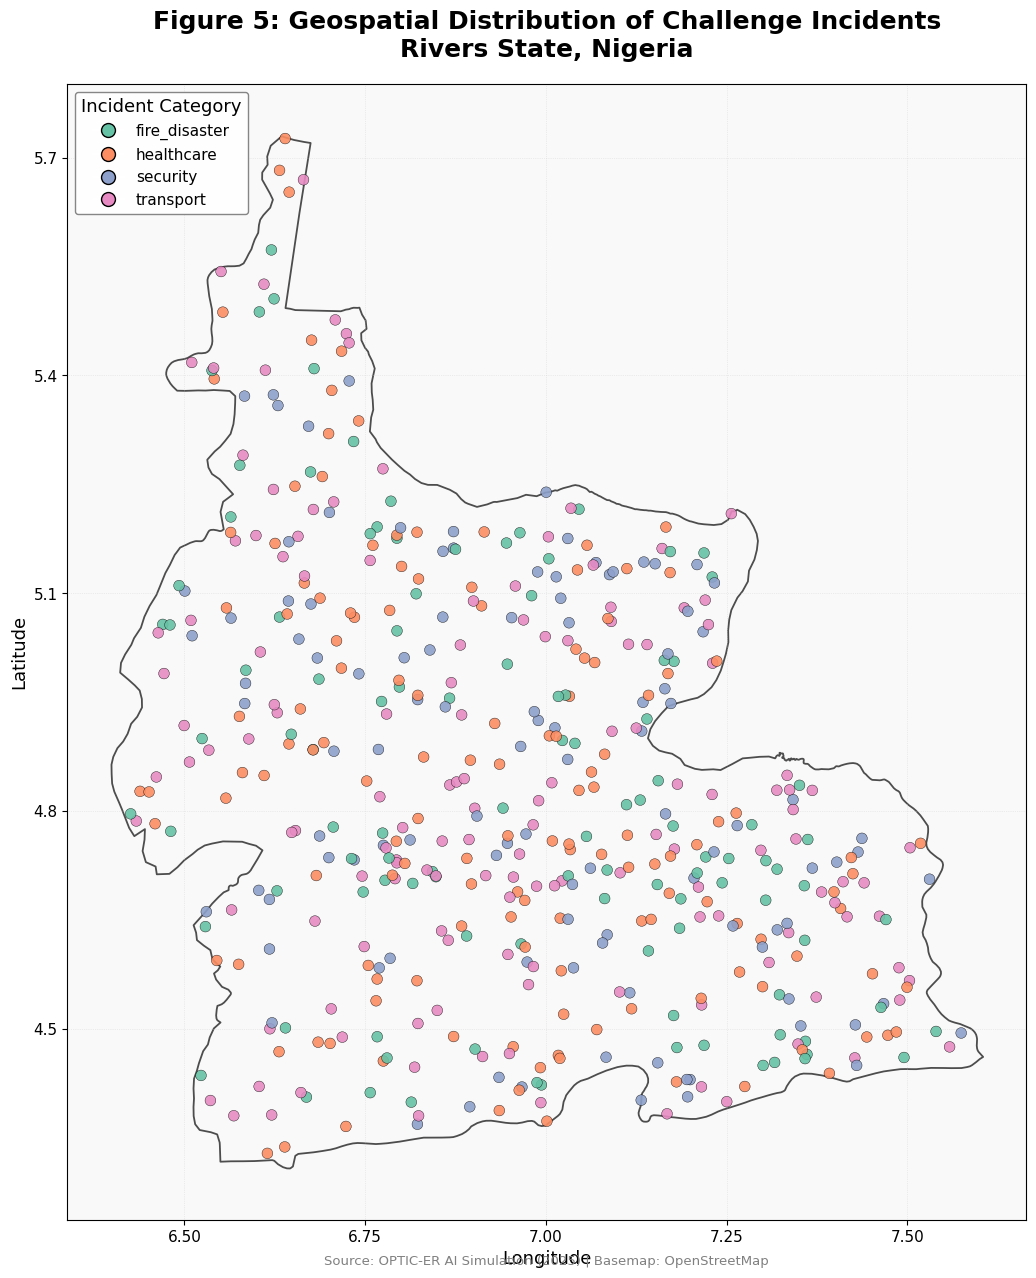

In [ ]:
# =============================================================================
# OPTIC-ER | Hold-Out Incident Distribution Map
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import osmnx as ox
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D

print("🧭 Plotting AI-Simulated Incident Distribution in Rivers State...")

# 1. Get Rivers State boundary
try:
    print("📦 Fetching boundary from OpenStreetMap...")
    rivers_state_boundary = ox.geocode_to_gdf(config.PLACE_NAME)
    print("✅ Boundary retrieved.")
except Exception as e:
    print(f"⚠️ Could not fetch boundary. Error: {e}")
    rivers_state_boundary = None

# 2. Define Colors and Style Parameters
BACKGROUND_COLOR = '#f9f9f9'
BORDER_COLOR = '#444444'
GRID_COLOR = '#cccccc'
PALETTE = sns.color_palette('Set2')  # Color-blind-friendly palette
MARKER_SIZE = 60

# 3. Create Figure
fig, ax = plt.subplots(figsize=(13, 13))
fig.patch.set_facecolor('white')

# 4. Plot Base Map
if rivers_state_boundary is not None:
    rivers_state_boundary.plot(
        ax=ax,
        facecolor=BACKGROUND_COLOR,
        edgecolor=BORDER_COLOR,
        linewidth=1.3,
        alpha=0.95,
        zorder=0
    )

# 5. Plot Incidents with Category Hue
sns.scatterplot(
    x=challenge_test_gdf.geometry.x,
    y=challenge_test_gdf.geometry.y,
    hue=challenge_test_gdf['category'],
    palette=PALETTE,
    s=MARKER_SIZE,
    edgecolor='black',
    linewidth=0.3,
    alpha=0.9,
    ax=ax,
    legend=False,
    zorder=2
)

# 6. Construct Custom Legend
categories = sorted(challenge_test_gdf['category'].unique())
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor=PALETTE[i], markeredgecolor='black',
           markersize=10, label=cat)
    for i, cat in enumerate(categories)
]
ax.legend(
    handles=legend_elements,
    title='Incident Category',
    title_fontsize=13,
    fontsize=11,
    loc='upper left',
    frameon=True,
    facecolor='white',
    edgecolor='gray',
    framealpha=0.95
)

# 7. Title and Axes Formatting
ax.set_title(
    'Figure 5: Geospatial Distribution of Challenge Incidents\nRivers State, Nigeria',
    fontsize=18, fontweight='bold', pad=20
)
ax.set_xlabel("Longitude", fontsize=13)
ax.set_ylabel("Latitude", fontsize=13)
ax.tick_params(axis='both', labelsize=11)
ax.grid(True, linestyle=':', color=GRID_COLOR, linewidth=0.5, alpha=0.6)
ax.set_facecolor(BACKGROUND_COLOR)

# 8. Axis Tick Refinement
ax.xaxis.set_major_locator(mticker.MaxNLocator(6))
ax.yaxis.set_major_locator(mticker.MaxNLocator(6))

# 9. Discreet Source Annotation
plt.annotate(
    "Source: OPTIC-ER AI Simulation (2025) | Basemap: OpenStreetMap",
    xy=(0.5, -0.04), xycoords='axes fraction',
    ha='center', fontsize=9.5, color='gray'
)

# 10. Final Layout & Display
plt.tight_layout(pad=1.5)
plt.show()

# Optional save:
fig.savefig("/content/drive/MyDrive/OpticER/data/incidents_map_Holdout_MIT_standard.png", dpi=300, bbox_inches='tight')
fig.savefig("/content/drive/MyDrive/OpticER/data/incidents_map_Holdout_MIT_standard.pdf", bbox_inches='tight')


In [ ]:
!pip freeze > requirements.txt